## Description

The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

The diagram below specifies the coordinate system used for the implementation of the pendulum’s dynamic equations.

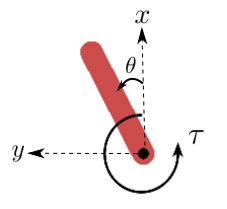

x-y: cartesian coordinates of the pendulum’s end in meters.

theta : angle in radians.

tau: torque in N m. Defined as positive counter-clockwise.
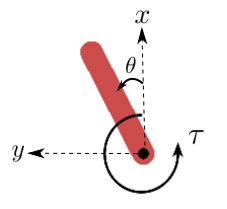

In [1]:
!pip install stable-baselines3[extra]
!pip install pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb python-opengl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.9 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=5ab2595629555b3d87ed

In [2]:
import os
import gymnasium as gym
import numpy as np
import random
import torch as th
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from stable_baselines3 import DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import CheckpointCallback


2025-07-10 05:15:48.940022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752124549.186123      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752124549.256439      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


error: XDG_RUNTIME_DIR not set in the environment.


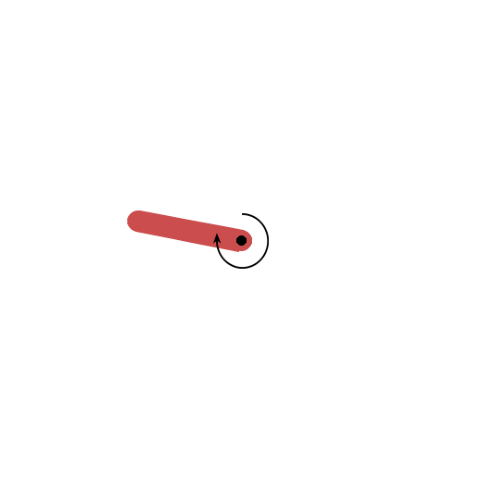

In [3]:
# Crear el entorno
env = gym.make("Pendulum-v1", render_mode="rgb_array")
observation, info = env.reset()

# Configurar matplotlib para visualización
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.axis('off')

frames = []  # Para almacenar los frames de la animación

for _ in range(200):  # 200 pasos de simulación
    # Tomar una acción aleatoria (en una aplicación real usarías tu política)
    action = env.action_space.sample()

    # Ejecutar un paso en el entorno
    observation, reward, terminated, truncated, info = env.step(action)

    # Renderizar el estado actual
    frame = env.render()
    frames.append(frame)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

# Función para crear la animación
def animate(i):
    ax.clear()
    ax.imshow(frames[i])
    ax.axis('off')

# Crear y mostrar la animación
anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())

In [4]:
# import torch
if torch.cuda.is_available():
    print("GPU está disponible.")
    device = torch.device("cuda")
else:
    print("GPU no está disponible. Usando CPU.")
    device = torch.device("cpu")
# Luego pasa 'device' a tu modelo o algoritmo

GPU no está disponible. Usando CPU.


In [5]:
# Set the seed for reproducibility
th.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Define the noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Create the DDPG agent
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=0)

In [6]:
# Train the agent
model.learn(total_timesteps=10000)

# Save the trained model
# model.save("ddpg_pendulum")
model_path = "/kaggle/working/ddpg_pendulum"
model.save(model_path)
loaded_model = DDPG.load(model_path)

error: XDG_RUNTIME_DIR not set in the environment.


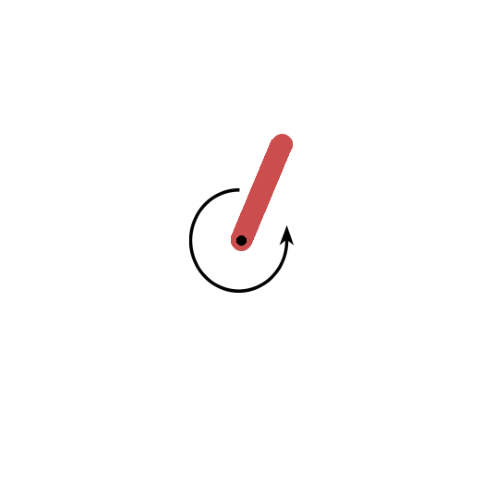

In [7]:
# Load the trained agent
# loaded_model = DDPG.load("ddpg_pendulum")

# Create the environment with render_mode="rgb_array" for visualization
eval_env = gym.make("Pendulum-v1", render_mode="rgb_array")

# Reset the environment
obs, info = eval_env.reset()

frames = []
for _ in range(200):
    # Predict the action using the trained model
    action, _states = loaded_model.predict(obs, deterministic=True)

    # Step the environment
    obs, reward, terminated, truncated, info = eval_env.step(action)

    # Render the state and append to frames
    frame = eval_env.render()
    frames.append(frame)

    if terminated or truncated:
        obs, info = eval_env.reset()

eval_env.close()

# Create and display the animation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plt.axis('off')

def animate(i):
    ax.clear()
    ax.imshow(frames[i])
    ax.axis('off')

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
HTML(anim.to_jshtml())